In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from scipy.stats.mstats import winsorize

In [24]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [3]:
df.columns = ['country', 'year', 'status', 'life_expectancy', 'adult_mortality', 'infant_death',
              'alc', 'per_expenditure', 'hepatitis', 'measles', 'bmi', 'underfive_death', 'polio',
              'tot_expenditure', 'diptheria', 'hiv', 'gdp', 'population', 'thin1_19', 'thin5_9',
              'income_composition', 'schooling']

In [4]:
for column in df:
    print('{}: '.format(column))
    print(df[column].unique())

country: 
['Afghanistan' 'Albania' 'Algeria' "Côte d'Ivoire" 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia (Plurinational State of)'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Slovakia'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland'
 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras'
 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran (

In [5]:
df2 = df.copy()
df2['population_null'] = pd.isnull(df.population)
df2['gdp_null'] = pd.isnull(df.gdp)
df2['hepatitis_null'] = pd.isnull(df.hepatitis)
df2['income_composition_null'] = pd.isnull(df.income_composition)
df2['schooling_null'] = pd.isnull(df.schooling)
df2['tot_expenditure_null'] = pd.isnull(df.tot_expenditure)

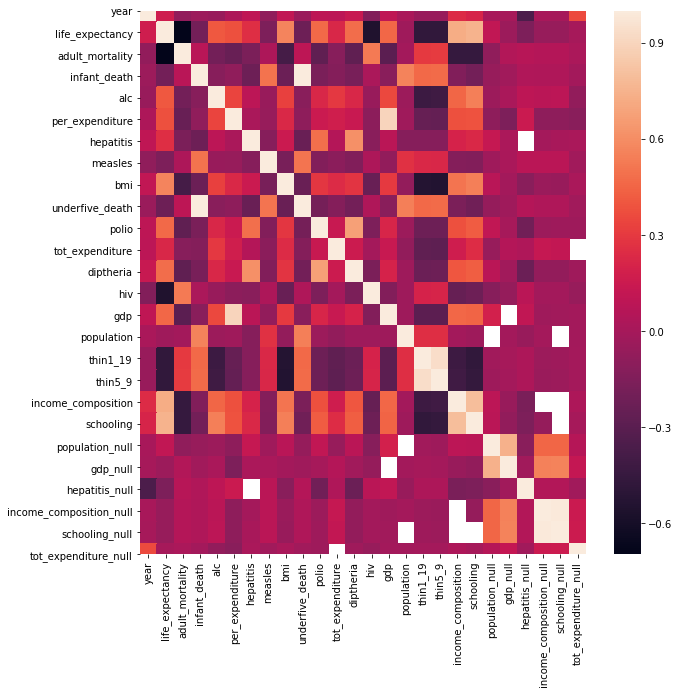

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df2.corr(), ax = ax)

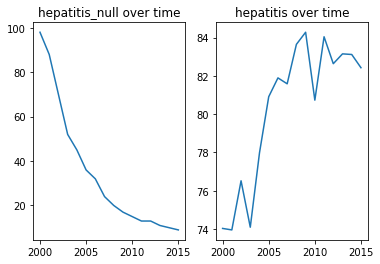

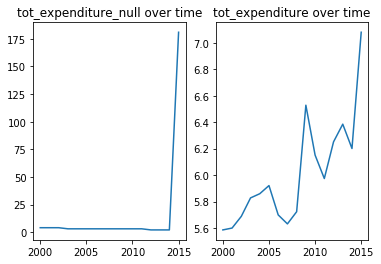

In [7]:
years  = df.year.unique()
hp_null_year = []
for year in years:
    hp_null_year.append(df2[df2.year == year].hepatitis_null.sum())
    
plt.subplot(1, 2, 1)
plt.plot(years, hp_null_year)
plt.title('hepatitis_null over time')

hep_year = []
for year in years:
    hep_year.append(df2[df2.year == year].hepatitis.mean())
    
plt.subplot(1, 2, 2)
plt.plot(years, hep_year)
plt.title('hepatitis over time')
plt.show()

tot_expenditure_null_year = []
for year in years:
    tot_expenditure_null_year.append(df2[df2.year == year].tot_expenditure_null.sum())
    
plt.subplot(1, 2, 1)
plt.plot(years, tot_expenditure_null_year)
plt.title('tot_expenditure_null over time')

exp_year = []
for year in years:
    exp_year.append(df2[df2.year == year].tot_expenditure.mean())
    
plt.subplot(1, 2, 2)
plt.plot(years, exp_year)
plt.title('tot_expenditure over time')
plt.show()

We can see that total expenditure's and hepatitis's missing values are correlated with year, but the other variables do not tend to be missing in relation to the other variables. tot_expenditure shouldn't be a cause for worry seeing as there are only a couple missing years, but hepatitis_null could be cause for concern. The values may not be missing at random, unlike the other variables.

In [8]:
#df[(df.infant_death == 0) | (df.infant_death > 60)]
#df[df.country == 'India']
## all of India's data is bad
## more specifically, India's data will be dropped because adult mortality, percentage expenditure, diptheria,
## hepatitis, and gdp randomly swing and infant and under five death are always above 1000.
#df[(df.measles == 0) | (df.measles > 450)]
##df[df.bmi >= 40]['country'].unique()
## bmi is clearly incorrect for over a hundred states, and should be thrown out entirely
## df[df.underfive_death >= 80].country.unique()
#df[df.per_expenditure >= 20]
## this data is garbage

In [9]:
df.describe()

,year,life_expectancy,adult_mortality,infant_death,alc,per_expenditure,hepatitis,measles,bmi,underfive_death,polio,tot_expenditure,diptheria,hiv,gdp,population,thin1_19,thin5_9,income_composition,schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


Variables are leftward biased, but that makes sense. quite a number of columns seem to have incorrect values at zero, as evidenced by the 25% quantiles at 0.

Winsorizing data to deal with outliers.

In [10]:
for column in df.columns[3:]:
    winsorize(df[column], limits = (.01, .01), inplace=True)

In [11]:
df.describe()

,year,life_expectancy,adult_mortality,infant_death,alc,per_expenditure,hepatitis,measles,bmi,underfive_death,polio,tot_expenditure,diptheria,hiv,gdp,population,thin1_19,thin5_9,income_composition,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2938.000000,2712.000000,2938.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.302110,165.992172,25.360109,4.602861,704.700818,80.956394,2008.327774,38.323795,35.930565,82.673928,5.939878,82.448945,1.654663,7483.272846,1.275338e+07,4.840668,4.870317,0.627551,12.022090
std,4.613841,9.516758,125.428454,68.287668,4.052413,1762.126967,25.021362,7436.889338,20.039415,99.340049,23.331526,2.495006,23.622030,4.437499,14270.109480,6.101210e+07,4.419171,4.508882,0.210904,3.265518
min,2000.000000,45.600000,4.000000,0.000000,0.010000,0.000000,6.000000,0.000000,2.300000,0.000000,6.000000,1.250000,6.000000,0.100000,24.242323,7.950000e+02,0.200000,0.100000,0.000000,2.900000
25%,2004.000000,63.200000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.260000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.755000,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.492500,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,88.000000,614.000000,498.000000,17.870000,10251.108720,99.000000,54190.000000,87.300000,773.000000,99.000000,17.600000,99.000000,29.500000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


Still some massive outliers on the right side for some of these columns, but means are generally unchanged.

Dropping or replacing other problem areas.

In [12]:
## drop infant deaths at 0 or above 60
df2 = df.drop(df[(df['infant_death'] == 0) | (df['infant_death'] > 60)].index)
indexes = df[(df['infant_death'] == 0) | (df['infant_death'] > 60)].index
for row in indexes:
    df.loc[row, 'infant_death'] = df2.infant_death.mean()

## drop India cause it's a mess
df.drop(df[df['country'] == 'India'].index, inplace = True)

## drop measles at 0 or above 450
df2 = df.drop(df[(df.measles == 0) | (df.measles > 450)].index)
indexes = df[(df.measles == 0) | (df.measles > 450)].index
for row in indexes:
    df.loc[row, 'measles'] = df2.measles.mean()

## drop deaths under five at or above 80 or below 1
df2 = df.drop(df[(df.underfive_death >= 80) | (df.underfive_death < 1)].index)
indexes = df[(df.underfive_death >= 80) | (df.underfive_death < 1)].index
for row in indexes:
    df.loc[row, 'underfive_death'] = df2.underfive_death.mean()
    
## drop  infant deaths below 1
df2 = df.drop(df[df.infant_death < 1].index)
indexes = df[df.infant_death < 1].index
for row in indexes:
    df.loc[row, 'infant_death'] = df2.infant_death.mean()
    
## drop bmi cause it is almost entirely incorrect
df.drop(['bmi'], axis = 1, inplace = True)

## drop percent expenditure above 20% or below 1%
df2 = df.drop(df[(df.per_expenditure >= 20) | (df.per_expenditure < 1)].index)
indexes = df[(df.per_expenditure >= 20) | (df.per_expenditure < 1)].index
for row in indexes:
    df.loc[row, 'per_expenditure'] = df2.per_expenditure.mean()

In [13]:
for column in df.columns[3:]:
    df[column].fillna(df[column].mean(), inplace = True)

Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

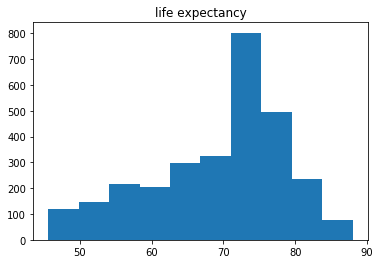

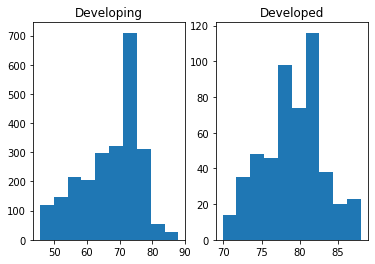

In [14]:
plt.hist(df.life_expectancy)
plt.title('life expectancy')
plt.show()

plt.subplot(1, 2, 1)
plt.title('Developing')
plt.hist(df[df.status == 'Developing'].life_expectancy)
plt.subplot(1, 2, 2)
plt.title('Developed')
plt.hist(df[df.status == 'Developed'].life_expectancy)
plt.show()

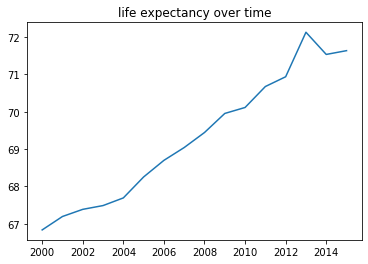

In [15]:
years  = df.year.unique()
le_year = []
for year in years:
    le_year.append(df[df.year == year].life_expectancy.mean())
    
plt.plot(years, le_year)
plt.title('life expectancy over time')
plt.show()

In [16]:
df2 = df.drop(['country', 'year', 'status'], axis = 1)
df2.corr()

,life_expectancy,adult_mortality,infant_death,alc,per_expenditure,hepatitis,measles,underfive_death,polio,tot_expenditure,diptheria,hiv,gdp,population,thin1_19,thin5_9,income_composition,schooling
life_expectancy,1.000000,-0.653726,-0.373275,0.383701,0.049203,0.200593,-0.109043,-0.349497,0.453401,0.215119,0.467674,-0.589493,0.426520,-0.013084,-0.500839,-0.495944,0.689970,0.723487
adult_mortality,-0.653726,1.000000,0.237212,-0.199101,-0.028559,-0.142177,0.064525,0.230662,-0.265004,-0.100370,-0.266794,0.532124,-0.276218,0.001064,0.313193,0.319933,-0.431769,-0.442214
infant_death,-0.373275,0.237212,1.000000,-0.209828,-0.045690,-0.104036,0.111010,0.792986,-0.218640,-0.016973,-0.208803,0.143646,-0.121997,0.102051,0.247307,0.262714,-0.272476,-0.340895
alc,0.383701,-0.199101,-0.209828,1.000000,0.045747,0.071118,-0.098134,-0.211615,0.209727,0.293322,0.211134,-0.058343,0.317416,-0.000255,-0.431359,-0.419859,0.415308,0.509148
per_expenditure,0.049203,-0.028559,-0.045690,0.045747,1.000000,0.027412,-0.007979,-0.056310,-0.015857,-0.000752,-0.025904,-0.052756,0.003623,0.019468,-0.008902,-0.024179,0.044083,0.039686
hepatitis,0.200593,-0.142177,-0.104036,0.071118,0.027412,1.000000,-0.034475,-0.098114,0.408793,0.044881,0.500542,-0.112154,0.059340,-0.022904,-0.068391,-0.071239,0.149331,0.172945
measles,-0.109043,0.064525,0.111010,-0.098134,-0.007979,-0.034475,1.000000,0.077640,-0.063956,-0.049306,-0.079237,0.059561,-0.021135,0.045289,0.113717,0.117397,-0.084591,-0.128722
underfive_death,-0.349497,0.230662,0.792986,-0.211615,-0.056310,-0.098114,0.077640,1.000000,-0.199842,-0.031673,-0.177942,0.165781,-0.127366,0.092178,0.251131,0.267548,-0.272702,-0.318762
polio,0.453401,-0.265004,-0.218640,0.209727,-0.015857,0.408793,-0.063956,-0.199842,1.000000,0.128531,0.674073,-0.183234,0.191514,-0.031782,-0.220382,-0.221406,0.342407,0.383343
tot_expenditure,0.215119,-0.100370,-0.016973,0.293322,-0.000752,0.044881,-0.049306,-0.031673,0.128531,1.000000,0.143809,-0.005387,0.120056,-0.089095,-0.271482,-0.278848,0.148192,0.225778


In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

underfive_death, adult_mortality, per_expenditure, hepatitis, polio, hiv, gdp, thin1_19, schooling are the least cocorrelated and most relevant. Hepatitis can be left out seeing as the data may not be missing at random and is correlated with polio well enough for polio to substitute for both.

In [17]:
core_df = df[['life_expectancy', 'underfive_death', 'per_expenditure', 'adult_mortality',
              'polio', 'hiv', 'gdp', 'thin1_19', 'schooling']]
core_df.corr()

,life_expectancy,underfive_death,per_expenditure,adult_mortality,polio,hiv,gdp,thin1_19,schooling
life_expectancy,1.000000,-0.349497,0.049203,-0.653726,0.453401,-0.589493,0.426520,-0.500839,0.723487
underfive_death,-0.349497,1.000000,-0.056310,0.230662,-0.199842,0.165781,-0.127366,0.251131,-0.318762
per_expenditure,0.049203,-0.056310,1.000000,-0.028559,-0.015857,-0.052756,0.003623,-0.008902,0.039686
adult_mortality,-0.653726,0.230662,-0.028559,1.000000,-0.265004,0.532124,-0.276218,0.313193,-0.442214
polio,0.453401,-0.199842,-0.015857,-0.265004,1.000000,-0.183234,0.191514,-0.220382,0.383343
hiv,-0.589493,0.165781,-0.052756,0.532124,-0.183234,1.000000,-0.145965,0.247039,-0.246212
gdp,0.426520,-0.127366,0.003623,-0.276218,0.191514,-0.145965,1.000000,-0.273884,0.439104
thin1_19,-0.500839,0.251131,-0.008902,0.313193,-0.220382,0.247039,-0.273884,1.000000,-0.478024
schooling,0.723487,-0.318762,0.039686,-0.442214,0.383343,-0.246212,0.439104,-0.478024,1.000000


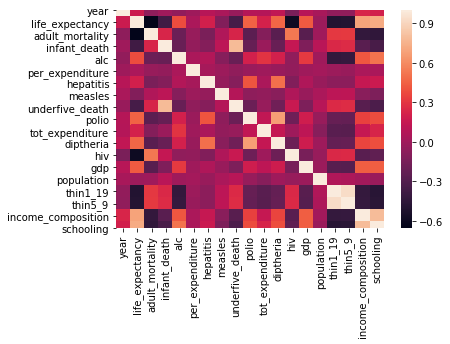

In [18]:
sns.heatmap(df.dropna().corr())

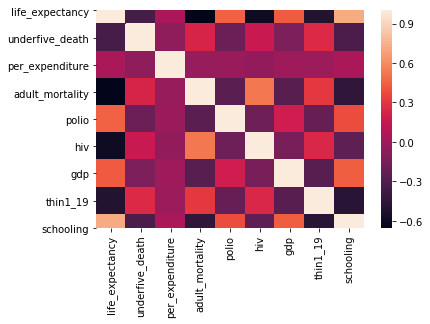

In [19]:
sns.heatmap(core_df.corr())

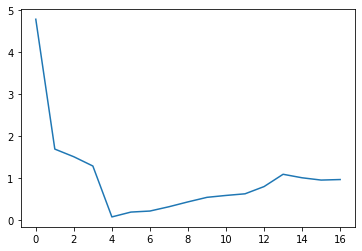

[4.78548563 1.68794231 1.50508949 1.28417942 0.07004887 0.18553745
 0.21017841 0.31278008 0.42879656 0.53709499 0.5823646  0.62133227
 0.79383286 1.08714427 1.00351852 0.94891607 0.96157812]


In [20]:
X = df.drop(['country', 'year', 'status', 'life_expectancy'], axis = 1)
X = StandardScaler().fit_transform(X)
Cx = np.cov(X.T)
eigval, eigvec = np.linalg.eig(Cx)
plt.plot(eigval)
plt.show()
print(eigval)

In [21]:
pca = PCA(n_components=4)
pca.fit_transform(X)
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.28140282 0.09925674 0.08850435 0.07551408]


Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

Clearly the data is well distributed across a number of components, but the primary variables that predict life expectancy appear to be under adult, mortality, five deaths, hiv contractions, polio vaccination, gdp, thinness, and schooling. In particular, polio vaccinations, hiv rates, schooling, and thinness (which can be interpreted as lack of nutrition), and gdp are most likely to effect life expectancy, with under five death rate and adult mortality also being strong predictors while not clearly being causes of life expectancy. Notably, expenditure on public health as a percent of gdp does not appear to correlate to higher life expectancy.

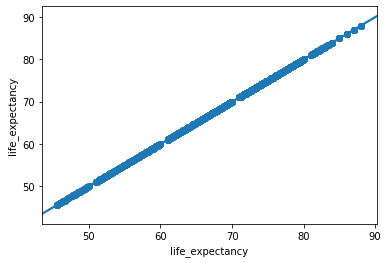

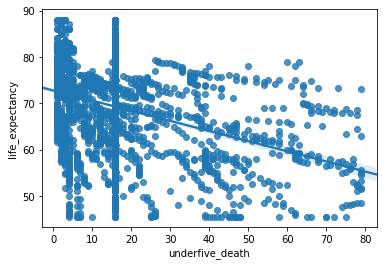

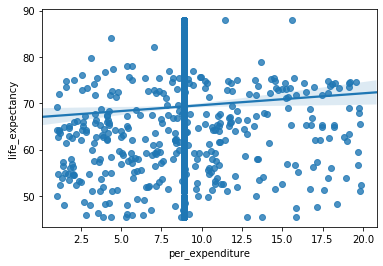

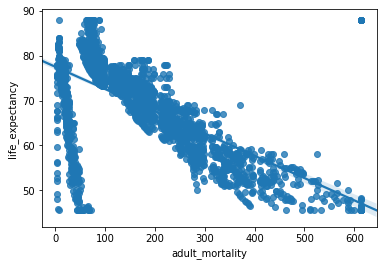

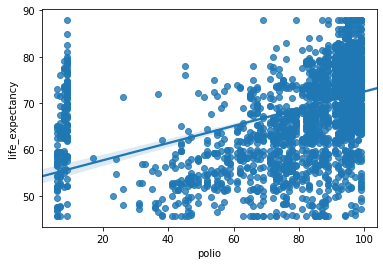

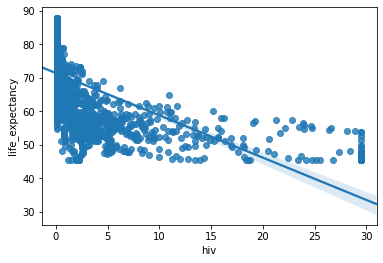

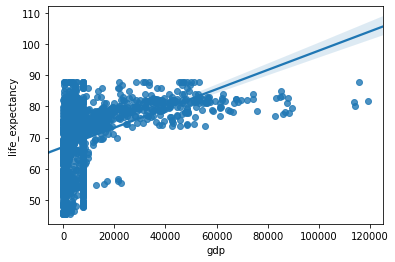

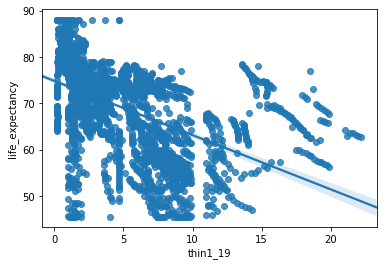

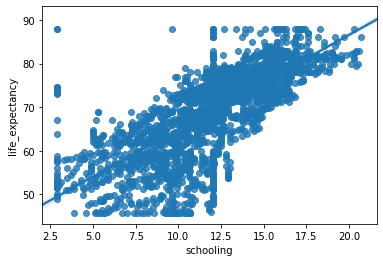

In [22]:
for column in core_df:
    sns.regplot(x = df[column], y = df.life_expectancy)
    plt.show()

In [23]:
df.describe()

,year,life_expectancy,adult_mortality,infant_death,alc,per_expenditure,hepatitis,measles,underfive_death,polio,tot_expenditure,diptheria,hiv,gdp,population,thin1_19,thin5_9,income_composition,schooling
count,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2.922000e+03,2922.000000,2922.000000,2922.000000,2922.000000
mean,2007.518823,69.323374,166.097878,13.980790,4.617486,8.878928,81.188791,82.809748,15.797447,82.745380,5.948673,82.533196,1.662320,7526.248077,9.872575e+06,4.717348,4.742486,0.628004,12.033925
std,4.613863,9.537496,125.600272,12.674828,3.921873,1.842086,22.332533,72.506213,15.259964,23.363409,2.400942,23.619265,4.448424,13163.367734,2.308246e+07,4.084029,4.155914,0.205276,3.177521
min,2000.000000,45.600000,4.000000,1.000000,0.010000,1.020072,6.000000,1.000000,1.000000,6.000000,1.250000,6.000000,0.100000,24.242323,7.950000e+02,0.200000,0.100000,0.000000,2.900000
25%,2004.000000,63.100000,74.000000,4.000000,1.080000,8.878928,81.188791,45.250000,4.000000,78.000000,4.380000,78.000000,0.100000,583.723224,4.125555e+05,1.600000,1.600000,0.504000,10.300000
50%,2008.000000,72.200000,144.000000,13.980790,4.170000,8.878928,87.000000,82.809748,15.797447,93.000000,5.948673,93.000000,0.100000,3151.439307,3.596420e+06,3.400000,3.400000,0.663500,12.100000
75%,2012.000000,75.800000,229.000000,13.980790,7.417500,8.878928,96.000000,82.809748,15.797447,97.000000,7.340000,97.000000,0.800000,7526.248077,9.872575e+06,7.100000,7.100000,0.773000,14.100000
max,2015.000000,88.000000,614.000000,60.000000,17.870000,19.897909,99.000000,450.000000,79.000000,99.000000,17.600000,99.000000,29.500000,119172.741800,2.581621e+08,22.200000,22.600000,0.948000,20.700000


## conclusion
After replacing an extensive amount of outliers and damaged values, we found several features which are both not strongly correlated with each other and are good predictors of life expectancy. The primary variables that predict life expectancy are under five deaths, hiv contractions, polio vaccinations, gdp, thinness, and schooling. vaccinations, hiv rates, schooling, and thinness (which can be interpreted as lack of nutrition), and gdp are most likely to effect life expectancy, with under five death rate and adult mortality also being strong predictors while not clearly being causes of life expectancy.